In [5]:
!pip install -qU flaml

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from flaml import tune
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Brief description of the problem and data
This project will look at the Fashion MNIST dataset [https://www.kaggle.com/datasets/zalando-research/fashionmnist/data] consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

This project seeks to develop a convolutional neural network (CNN) to accurately determine what type of garment is shown in a particular image, such as `T-shirt/top`, `Trouser`, or `Pullover`.  The full mapping of all labels is shown below.  The next snippet of code below that displays a few examples from the training dataset along with the associated label.

My Github repository link: [https://github.com/rakin23/deep-learning-week-6]

In [65]:
# Map the numerical labels (0, 1, 2...) to text labels (T-shirt/top, Trouser, Pullover...)
label_to_text_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [66]:
data_loc = 'fashion-mnist-data'

# Load train and test data
train_data = pd.read_csv(data_loc + "/fashion-mnist_train.csv")
Y_train = train_data['label'].values
X_train = train_data.drop(columns=['label']).values / 255.0  # Normalize to [0, 1]
test_data = pd.read_csv(data_loc + "/fashion-mnist_test.csv")
Y_test = test_data['label'].values
X_test = test_data.drop(columns=['label']).values / 255.0  # Normalize to [0, 1]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 28, 28)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 28, 28)
Y_test = torch.tensor(Y_test, dtype=torch.long)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

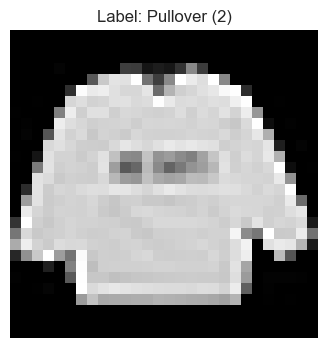

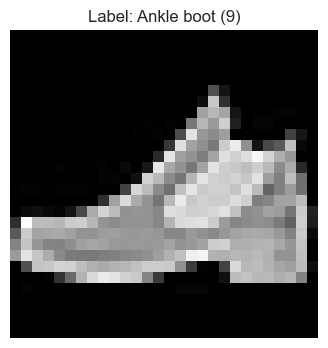

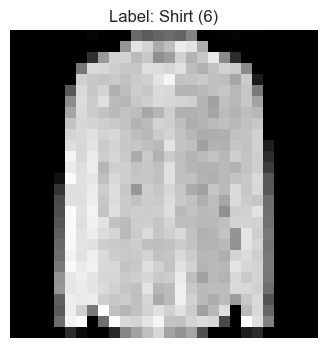

In [67]:
def display_image(data, index=0, title="Label"):
    # The first column is the label and the rest are pixel values
    labels = data.iloc[:, 0]
    images = data.iloc[:, 1:].values

    label = labels[index]
    image = images[index]

    # Reshape the flat image array into a 28x28 grid since all fashion MNIST images are 28x28 pixels
    image = image.reshape(28, 28)

    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap="gray")
    plt.title(f"{title}: {label_to_text_map[label]} ({label})")
    plt.axis("off")
    plt.show()

# Display a few example images
display_image(train_data, index=0)
display_image(train_data, index=1)
display_image(train_data, index=2)

I found this dataset interesting because it seeks to replace the well-known MNIST dataset [https://en.wikipedia.org/wiki/MNIST_database] as the benchmark to validate algorithms in the AI/ML/Data Science community.  I plan to use the skills I am learning in this course in my future career, so knowing how to use this benchmark dataset along with the MNIST dataset will help me do benchmark testing on any ML models I develop later.

I also found the small size of this dataset appealing (the training dataset is 133MB) because it would allow me to iterate quickly on the model without needing to wait hours to train a single model.  I found this especially appealing after week 5's GAN assignment, in which training took 1 or more hours!

# Step 2: Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data
In this step, I will take a look at the data set, call out any areas of concern, and summarize my findings at the end.

## Step 2.1: Confirmation of provided data
Kaggle states that the dataset contains a training set of 60,000 examples and a test set of 10,000 examples, which are all 28x28 grayscale images.  28x28 = 784, so I would expect the shape to by 785 (including 1 additional column for the data label).

Kaggle states that there are 10 unique data labels (0 through 9).

I trust Kaggle, but let's verify their claims just in case there is a mistake in the data description of the data itself.

In [68]:
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Unique train labels:", np.unique(Y_train))
print("Unique test labels:", np.unique(Y_test))


Train data shape: (60000, 785)
Test data shape: (10000, 785)
Unique train labels: [0 1 2 3 4 5 6 7 8 9]
Unique test labels: [0 1 2 3 4 5 6 7 8 9]


The data shape and number of unique labels matches the description of the data in Kaggle.

## Step 2.2: Label distribution
Next I'll check the distribution of samples across the classes to ensure there is no significant imbalance.  If there is, I may have to oversample the minority classes, undersample the majority classes, or perform data augmentation such as by applying transformations like rotating, flipping, or cropping.

<Axes: xlabel='None', ylabel='count'>

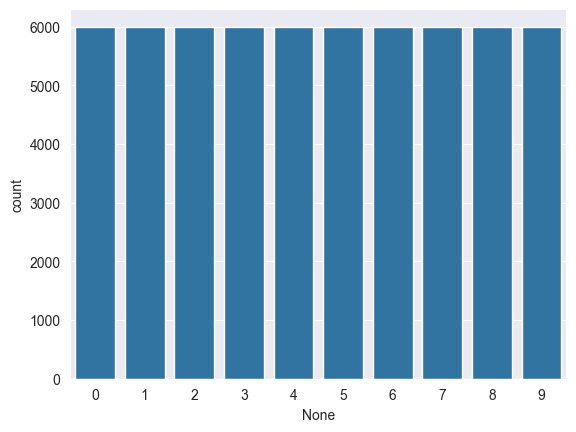

In [69]:
sns.countplot(x=Y_train)

The training data is perfectly balanced (!!) with 6,000 samples in each of 10 categories.

## Step 2.3: Pixel intensity analysis
Here I'll check the range of pixel intensities.  These are typically 0–255 for grayscale images, with 0 = white and 255 = black, but I've normalized this dataset above to fall between 0-1.

Training Dataset Pixel Intensity Analysis:
Mean Pixel Intensity: 0.2861
Standard Deviation: 0.3528
Min Pixel Intensity: 0.0000
Max Pixel Intensity: 1.0000


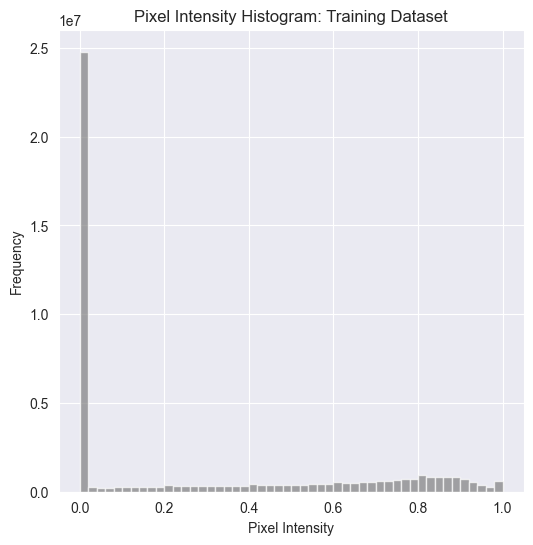

Testing Dataset Pixel Intensity Analysis:
Mean Pixel Intensity: 0.2869
Standard Deviation: 0.3540
Min Pixel Intensity: 0.0000
Max Pixel Intensity: 1.0000


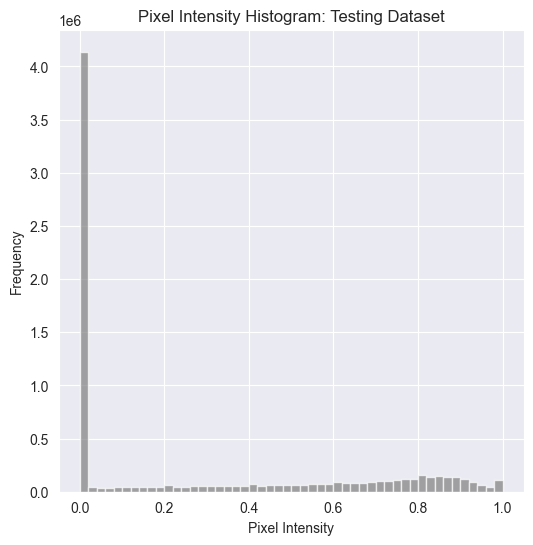

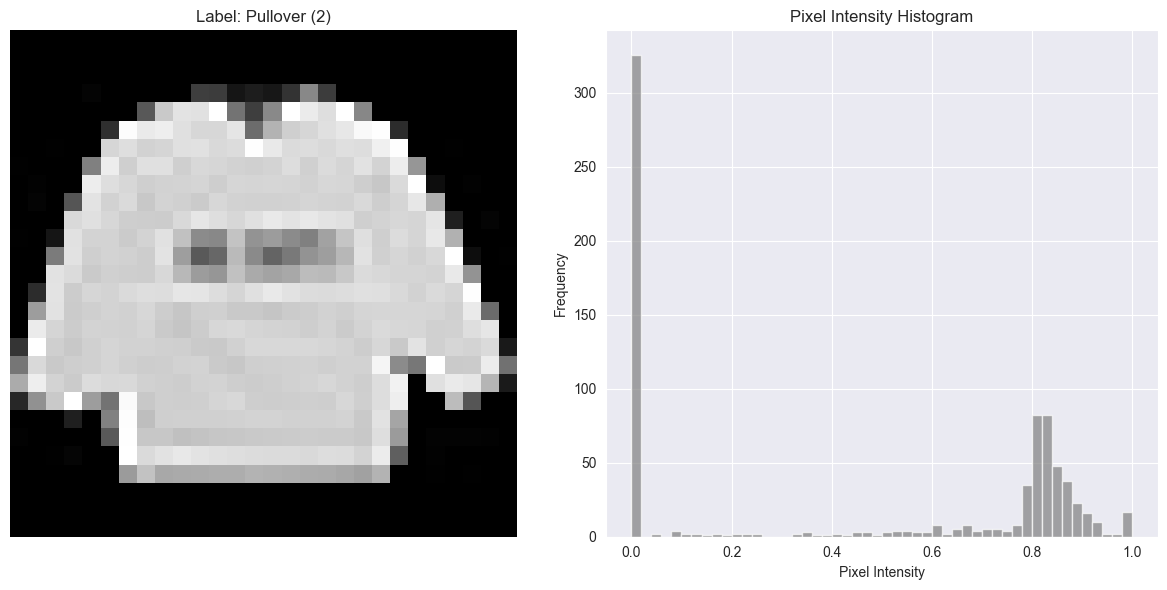

In [70]:
# Function to compute and plot pixel intensity analysis
def pixel_intensity_analysis(dataset, title="Dataset"):
    # Flatten the images to compute pixel-wise statistics
    images = dataset.tensors[0].view(-1, 28*28)  # Flatten to 1D vector (28*28)

    # Compute pixel intensity statistics
    pixel_mean = images.mean().item()  # Mean pixel intensity
    pixel_std = images.std().item()    # Standard deviation
    pixel_min = images.min().item()    # Minimum pixel intensity
    pixel_max = images.max().item()    # Maximum pixel intensity

    # Print the statistics
    print(f"{title} Pixel Intensity Analysis:")
    print(f"Mean Pixel Intensity: {pixel_mean:.4f}")
    print(f"Standard Deviation: {pixel_std:.4f}")
    print(f"Min Pixel Intensity: {pixel_min:.4f}")
    print(f"Max Pixel Intensity: {pixel_max:.4f}")

    # Plot histogram of pixel intensities
    plt.figure(figsize=(6, 6))
    plt.hist(images.flatten().numpy(), bins=50, color='gray', alpha=0.7)
    plt.title(f"Pixel Intensity Histogram: {title}")
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Perform pixel intensity analysis on training and testing datasets
pixel_intensity_analysis(train_dataset, "Training Dataset")
pixel_intensity_analysis(test_dataset, "Testing Dataset")

def display_image_with_histogram(dataset, index=0):
    # Get the image and label at the given index
    image = dataset.tensors[0][index].squeeze().numpy()  # (1, 28, 28) -> (28, 28)
    label = dataset.tensors[1][index].item()

    # Plot the image and its pixel intensity histogram
    plt.figure(figsize=(12, 6))

    # Plot image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label_to_text_map[label]} ({label})")
    plt.axis('off')

    # Plot pixel intensity histogram
    plt.subplot(1, 2, 2)
    plt.hist(image.flatten(), bins=50, color='gray', alpha=0.7)
    plt.title(f"Pixel Intensity Histogram")
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Display a single example image with its pixel intensity histogram from the training dataset
display_image_with_histogram(train_dataset, index=0)

* Both the training and test datasets have a very large spike at the beginning of the pixel intensity distributions due to the white backgrounds used in the images.
* Both datasets have a small spike at the end of the pixel intensity distributions due to the black outline used in some images.
* The distribution of pixel intensities across the training dataset looks nearly identical to the distribution across the test dataset.
* If you ignore the white (0) and black (1) intensities, the pixel intensity distribution shows an average around 0.8, with the bell curve favoring the darker intensities between 0.6-0.9.  There are much fewer pixels in the lower intensities 0.1-0.5.

## Step 2.4: Class heatmaps
This section will generate and display heatmaps of averaged images for each class (i.e. "T-shirt/top", "Trouser")

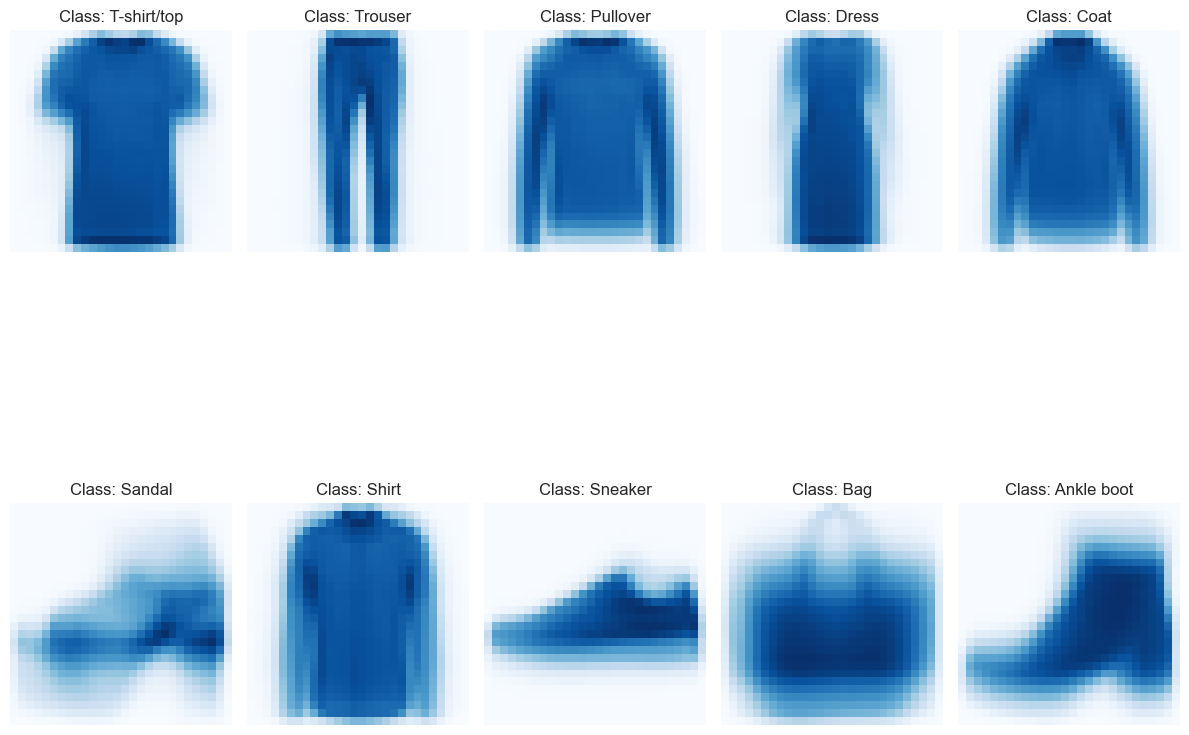

In [71]:
def generate_class_heatmaps(dataset):
    # Initialize a list to store images for each class
    class_images = {i: [] for i in range(10)}

    # Loop through the dataset and group images by their labels
    for i in range(len(dataset)):
        image, label = dataset[i]
        class_images[label.item()].append(image.squeeze().numpy())  # Remove channel dimension for 2D image

    # Plot averaged images with heatmaps for each class
    plt.figure(figsize=(12, 12))

    for label, images in class_images.items():
        # Compute the average image for each class
        avg_image = np.mean(images, axis=0)

        # Plot the averaged image as a heatmap
        plt.subplot(2, 5, label + 1)
        sns.heatmap(avg_image, cmap='Blues', square=True, cbar=False, xticklabels=False, yticklabels=False)
        plt.title(f"Class: {label_to_text_map[label]}")

    plt.tight_layout()
    plt.show()

generate_class_heatmaps(train_dataset)

The clarity of the heatmaps above tells us a few interesting things.
1. The shapes in these images are easily recognizable to the human eye.
2. The training dataset likely does not contain many rotated or skewed images (perhaps it contains none), and instead contains images with the garment right side up with `Sandal`/`Sneaker`/`Ankle boot` with the toes pointed left.
3. The training dataset likely contains most/all images captured looking at the item from a consistent angle.  For example, a photo of a shirt in real life may be taken with the shirt hanging on a hanger or balled up on the floor, but these heatmaps suggest that all `Shirt` images in this dataset are taken with the shirt hanging on a hanger as viewed from the angle where the shirt appears as if it's being worn by a person looking at the camera.
4. `Sandals` and `Bags` have the most "fuzziness" in the heatmaps, indicating that these categories are less consistent than the others.  A bit of "fuzziness" can also be seen `Dress` and `Shirt` categories in the sleeves, which intuitively makes sense since some dresses and shirts have sleeves while others don't.

Based on the consistency of this dataset, I am optimistic that I will be able to generate a well-performing model.  Let's see if I'm right!

## Step 2.5: Blank images

In [72]:
def identify_blank_images(dataset):
    blank_images = []

    for i in range(len(dataset)):
        image, label = dataset[i]

        # Flatten the image to 1D for analysis
        flattened_image = image.squeeze().numpy().flatten()

        # Check if the image is blank (all pixels are zero)
        if np.all(flattened_image == 0):
            blank_images.append(i)

    print(f"Number of blank images: {len(blank_images)}")
    return blank_images

# Identify blank and noisy images in the training dataset
blank_images = identify_blank_images(train_dataset)

# Display some examples of blank images
def display_images(dataset, image_indices, title="Images"):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(image_indices):
        image = dataset[idx][0].squeeze().numpy()  # Get image and remove channel dimension
        plt.subplot(1, len(image_indices), i + 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Image {idx}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display blank images
if blank_images:
    display_images(train_dataset, blank_images[:5], title="Blank Images")

Number of blank images: 0


## Step 2.6: EDA summary
In the EDA above I performed the following 5 tasks
1. **Confirmation of provided data**: The description of the data from Kaggle is accurate
2. **Label distribution**: The training data is perfectly evenly distributed (6,000 samples in each of 10 categories)
3. **Pixel intensity analysis**: White (pixel intensity = 0) is the most common due to the backgrounds.  Black (pixel intensity = 255) is relatively common due to the black outline around some items.  The distribution of intensities is roughly the same across the training and test datasets.
4. **Class heatmaps**: The images in the training dataset were captured at an angle that is highly consistent with no rotation or skew.  For example, all 3 categories of shoes (`Sandal`, `Sneaker`, and `Ankle boot`) have the base towards the bottom of the image and the toes pointed left.
5. **Blank images**: There are no blank images.

Put simply, this dataset is of very high quality!

# Step 3: Model Architecture
I have chosen to use a CNN (convolutional neural network) to view the images in the test dataset and to predict their category (i.e. "T-shirt/top", "Trouser").  I chose a CNN because this type of model is widely used for image classification tasks due to its ability to automatically learn spatial hierarchies of features, which is especially useful for visual pattern recognition.

I will build a CNN with two convolutional layers (`conv1` and `conv2`), followed by batch normalization (`bn1`, `bn2`, `bn3`), pooling, and two fully connected layers (`fc1` and `fc2`).

The constructor accepts parameters for the number of output channels for the convolutional layers (`conv1_out`, `conv2_out`) and the number of neurons in the first fully connected layer (`fc1_out`), allowing some flexibility in the architecture and easy hyperparameter tuning later.

I've chosen to set `stride` to 1 due to the small dataset and expected quick training time.  Larger datasets that take a long time to train could speed up training time by increasing the stride.

In [73]:
# Check if MPS is available.  I am using a Mac M2, so the availability of "MPS" indicates I can use the GPU to speed up training.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [74]:
class SimpleCNN(nn.Module):
    def __init__(self, conv1_out=32, conv2_out=64, fc1_out=128):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(conv1_out)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(conv2_out)
        self.fc1 = nn.Linear(conv2_out * 7 * 7, fc1_out)
        self.bn3 = nn.BatchNorm1d(fc1_out)
        self.fc2 = nn.Linear(fc1_out, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        return x

In [76]:
# Training function that accepts input config options including conv1_out, conv2_out, fc1_out, batch_size, lr, and epochs
def train_fashion_mnist(config):
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
    model = SimpleCNN(conv1_out=config['conv1_out'], conv2_out=config['conv2_out'], fc1_out=config['fc1_out']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    train_losses = []
    test_losses = []

    # Training loop
    for epoch in range(config['epochs']):
        model.train()
        epoch_train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Evaluate the model on the test set
        model.eval()
        epoch_test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                epoch_test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        # Average test loss for the epoch
        epoch_test_loss /= len(test_loader)
        test_losses.append(epoch_test_loss)

        print(f"Epoch {epoch + 1}/{config['epochs']}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Test Loss: {epoch_test_loss:.4f}, "
              f"Test Accuracy: {correct / total:.4f}")

    accuracy = correct / total
    return {'accuracy': accuracy, 'model': model, 'train_losses': train_losses, 'test_losses': test_losses}

In [85]:
baseline_config_space = {
    'conv1_out': 32,
    'conv2_out': 64,
    'fc1_out': 128,
    'batch_size': 64,
    'lr': 1e-2,
    'epochs': 5,
}

baseline_result = train_fashion_mnist(baseline_config_space)

print("Baseline configuration = {")
for key, value in baseline_config_space.items():
    print(f"    '{key}': {value},")
print("}")
print("Baseline accuracy =", baseline_result['accuracy'])

Baseline configuration = {
    'conv1_out': 32,
    'conv2_out': 64,
    'fc1_out': 128,
    'batch_size': 64,
    'lr': 0.01,
    'epochs': 5,
}
Baseline accuracy = 0.919


# Step 4: Results and Analysis
The baseline model performed decently with an accuracy of 0.919.  Let's see if we can improve that using hyperparameter tuning.

In [87]:
# Define the search space for hyperparameter tuning
config_space = {
    'conv1_out': tune.choice([16, 32, 64]),
    'conv2_out': tune.choice([32, 64, 128]),
    'fc1_out': tune.choice([64, 128, 256]),
    'batch_size': tune.choice([32, 64, 128]),
    'lr': tune.loguniform(1e-4, 1e-2),
    'epochs': tune.choice([5, 10, 15]),
}

# Use FLAML (Fast and Lightweight AutoML) to do hyperparameter tuning
analysis = tune.run(
    train_fashion_mnist,
    config=config_space,
    metric='accuracy',
    mode='max',
    num_samples=5,  # Fewer trials for faster tuning
    resources_per_trial={'cpu': 2, 'gpu': 1},  # Use GPU
    local_dir='./flaml_results',  # Directory to save results
)

best_config = analysis.best_config
print("Best configuration:", best_config)

Epoch 1/5, Train Loss: 0.4167, Test Loss: 0.2667, Test Accuracy: 0.9036
Epoch 2/5, Train Loss: 0.2432, Test Loss: 0.2292, Test Accuracy: 0.9174
Epoch 3/5, Train Loss: 0.2043, Test Loss: 0.2157, Test Accuracy: 0.9219
Epoch 4/5, Train Loss: 0.1786, Test Loss: 0.2109, Test Accuracy: 0.9250
Epoch 5/5, Train Loss: 0.1561, Test Loss: 0.2108, Test Accuracy: 0.9241
Epoch 1/5, Train Loss: 0.4032, Test Loss: 0.2622, Test Accuracy: 0.9072
Epoch 2/5, Train Loss: 0.2440, Test Loss: 0.2289, Test Accuracy: 0.9137
Epoch 3/5, Train Loss: 0.2054, Test Loss: 0.2226, Test Accuracy: 0.9176
Epoch 4/5, Train Loss: 0.1805, Test Loss: 0.2104, Test Accuracy: 0.9209
Epoch 5/5, Train Loss: 0.1567, Test Loss: 0.2122, Test Accuracy: 0.9216
Epoch 1/10, Train Loss: 0.4635, Test Loss: 0.2726, Test Accuracy: 0.9045
Epoch 2/10, Train Loss: 0.2549, Test Loss: 0.2352, Test Accuracy: 0.9170
Epoch 3/10, Train Loss: 0.2138, Test Loss: 0.2274, Test Accuracy: 0.9171
Epoch 4/10, Train Loss: 0.1865, Test Loss: 0.2100, Test Accur

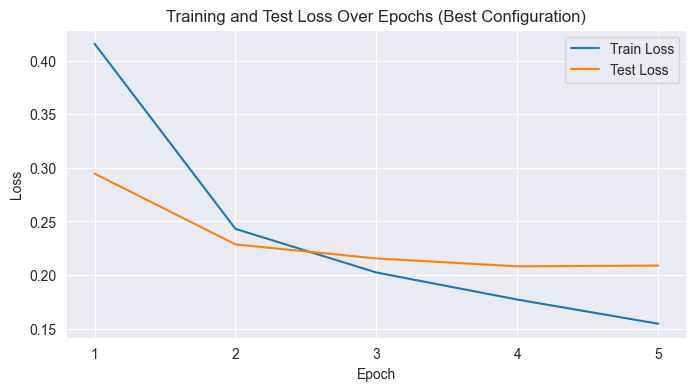

Model saved to 'best_model.pth'


In [93]:
# Train with the best configuration
# best_result = train_fashion_mnist(best_config)
# print("Best accuracy:", best_result['accuracy'])

# Plot the loss curves
plt.figure(figsize=(8, 4))
plt.plot(best_result['train_losses'], label='Train Loss')
plt.plot(best_result['test_losses'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs (Best Configuration)')
plt.xticks(range(len(best_result['train_losses'])), range(1, len(best_result['train_losses']) + 1))  # Adjust x-axis labels
plt.legend()
plt.show()

# Save the trained model
model = best_result['model']
torch.save(model.state_dict(), 'best_model.pth')
print("Model saved to 'best_model.pth'")

# Step 5: Conclusion
In this notebook I summarized the problem statement (to train a CNN to correctly identify which type of item is in an image from the Fashion MNIST dataset), performed an EDA on the dataset, developed a baseline model, then improved on that model using hyperparameter tuning.

